# Детекция объектов и фигуры

In [3]:
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import binary_closing, binary_erosion, binary_opening
from scipy import ndimage
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_minimum
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label
import matplotlib.patches as patches
from PIL import Image,ImageDraw 
import os
from imageio import imread, imsave
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv


def show_example_data(data):
    fix, ax = plt.subplots(4,3, figsize=(30,30))
    for i, elem in enumerate(data):
        ax.flat[i].imshow(elem)
    


def get_example_data(show_data = False):
    example_data = []
    path = 'inputs_example'
    for file in os.listdir(path):
        img = imread(os.path.join(path, file))
#         print(img.shape)
        example_data.append(img)
    if show_data:
        show_example_data(example_data)
    return example_data


def get_path_data(path ,show_data = False):
    example_data = []
    path = path
    for file in os.listdir(path):
        img = imread(os.path.join(path, file))
#         print(img.shape)
        example_data.append(img)
    if show_data:
        show_example_data(example_data)
    return example_data


def get_largest_area_boxes(mask):
    result_boxes = []
    labels = sk_measure_label(~mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    for prop in props:
        if prop.area > 1200: # TODO ЭТо потенцияально зависящая от размеров изображения дырааааа.
            box = prop.bbox
            result_boxes.append(box)
    
    return result_boxes


def get_rect(x, y, width, height, angle):
    rect = np.array([(0, 0), (width, 0), (width, height), (0, height), (0, 0)])
    theta = (np.pi / 180.0) * angle
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    offset = np.array([x, y])
    transformed_rect = np.dot(rect, R) + offset
    return transformed_rect


def get_object_boxes(gray_img):
    upper_threshold = threshold_minimum(gray_img) # get only objects on image
    mask = gray_img >= upper_threshold 
#     plt.imshow(mask)
#     plt.show()
    return get_largest_area_boxes(mask) 


def get_object_and_figure_boxes(main_img):
    
    gray_img = rgb2gray(main_img)
    
#     upper_threshold = threshold_minimum(gray_img) # get only objects on image
#     mask = gray_img >= upper_threshold 
    objects_boxes = get_object_boxes(gray_img) # Get object bbox

    edges = canny(gray_img, sigma=1.5, low_threshold=0.1) 
    
    working_img = Image.fromarray(edges) 
    draw = ImageDraw.Draw(working_img)
    for box in objects_boxes: # paint black boxes where object bbox exist
        min_row, min_col, max_row, max_col = box
        rect = get_rect(max(min_col-20,0),max(min_row-20, 0), width=max_col- min_col+20, height= max_row - min_row + 20, angle=0)
        draw.polygon([tuple(p) for p in rect], fill=0)
    edges = np.asarray(working_img)
    edges  = binary_closing(edges, selem=np.ones((4, 4)))
    my_edge_segmentation = binary_fill_holes(binary_closing(edges, selem=np.ones((7, 7))))
    my_edge_segmentation = binary_opening(my_edge_segmentation, selem=np.ones((10, 10)))
    edge_boxes = get_largest_area_boxes(~my_edge_segmentation)
    
    return edge_boxes,objects_boxes 


def get_bboxes_example_show(show_data = True):
    data = get_example_data(show_data = show_data)
    fix, ax = plt.subplots(4,3, figsize=(30,30))

    for indx, main_img in enumerate(data):
        edge_boxes,  objects_boxes = get_object_and_figure_boxes(main_img)
        ax.flat[indx].imshow(main_img, cmap = "gray")
        for box in objects_boxes:
            min_row, min_col, max_row, max_col = box
            ax.flat[indx].add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='r', facecolor='none'))
        for box in edge_boxes:
            min_row, min_col, max_row, max_col = box
            ax.flat[indx].add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='b', facecolor='none'))
    fix.tight_layout()
    plt.show()
    
    
def cut_objects_from_image(image, bboxes, resize = True):
#     print(image.shape)
    add_area = 10
    images = []
    img_row, img_col, _ = image.shape
    for box in bboxes:
        min_row, min_col, max_row, max_col = box
        roi = image[max(min_row-add_area,0): min(max_row+add_area,img_row), max(min_col-add_area,0): min(max_col+add_area,img_col)]
#         plt.imshow(roi)
#         plt.show()
        im = Image.fromarray(np.uint8(roi))
        if resize:
            im = im.resize((128, 128),Image.ANTIALIAS)
#         im.show()
        img =  np.array(im)
#         plt.imshow(img)
#         plt.show()
        images.append(img)
    
    return images
    
# get_bboxes_example_show(show_data = False)
# data = get_example_data(show_data = False)


# Генерация тренировочных фоточек

In [ ]:
# Генерируем тренировочные наборы
cls_path  = 'classifyer_imgs'
path = "6"
cut_path = "6_cut"
data = get_path_data(os.path.join(cls_path, path))
print(len(data))
for indx, img in enumerate(data):
    plt.imshow(img)
    plt.show()
    objects_boxes  = get_object_boxes(rgb2gray(img))
    objects = cut_objects_from_image(img,objects_boxes)
    for j , obj in enumerate(objects):
#     plt.imshow(obj)
#     plt.show()
        imsave(os.path.join(cut_path, f"{indx}_{j}.jpg"),obj)
#     break

# Обучение классификатора

In [6]:
from sklearn.model_selection import train_test_split
def create_vector(size, elem):
    arr = np.zeros(size)
    arr[elem] = 1
    return arr

X = []
Y = []
cls_path  = 'classifyer_imgs'
folders = ['1_cut', "2_cut","3_cut" , "4_cut", "5_cut", "6_cut", "7_cut", "8_cut"]
indx_to_name  = {0:"Значок" , 1:"Пульт", 2:"Зажигалка", 3: "Медиатор", 4: "Шахматный конь", 5:"Крышка", 6: "Кубик", 7: "Батарейка"}
for indx, folder in enumerate(folders):
    for file in os.listdir(os.path.join(cls_path,folder)):
        img = imread(os.path.join(cls_path,folder, file))
        X.append(img)
        Y.append(create_vector(len(folders), indx))
        
        
# counter = dict()
from collections import Counter
counter = Counter()
for vector in Y:
    counter[np.argmax(vector)]+=1
    
print(counter)
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X), np.array(Y), test_size=0.4, shuffle = True)
# print(np.array(X).shape)

Counter({1: 22, 2: 22, 4: 21, 0: 20, 6: 19, 3: 17, 5: 17, 7: 13})


In [7]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from keras import Model, Input
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Reshape, GlobalMaxPooling2D,
                          Activation)
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import BatchNormalization

def make_fashion_model(num_classes):
    imodel = Sequential()
    imodel.add(Reshape((128, 128, 3), input_shape=(128, 128, 3)))
    imodel.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    
    
    imodel.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(Flatten())

    iclf = Sequential()
    iclf.add(imodel)
    iclf.add(Dense(num_classes, activation='softmax'))

    iclf.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return iclf




In [8]:
from keras.preprocessing.image import ImageDataGenerator

# здесь следует изменить параметры аугментации:
aug = ImageDataGenerator(featurewise_center=False,
                   samplewise_center=False,
                   featurewise_std_normalization=False,
                   samplewise_std_normalization=False,
                   rotation_range= 60,
                   width_shift_range=0,
                   height_shift_range=0,
                   brightness_range=None,
                   shear_range = 0.0,
                   zoom_range=[0.9, 1.05],
                   channel_shift_range=0.0,
                   fill_mode='nearest',
                   cval=0.0,
                   horizontal_flip=False,
                   vertical_flip=False,
                   rescale=None)

In [9]:
batch_size = 4
fashion_clf = make_fashion_model(num_classes = len(folders))
train_X_train = X_train.copy()
# print(train_fashion_images.shape)
aug.fit(train_X_train)

gen = aug.flow(train_X_train, y_train,
               batch_size=batch_size)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist = fashion_clf.fit(gen,
               steps_per_epoch=len(train_X_train) // batch_size,
               epochs=50,
               validation_data=(X_test, y_test),callbacks=[model_checkpoint_callback])


Epoch 1/50
22/22 [==============================] - 2s 62ms/step - loss: 2.0120 - accuracy: 0.4651 - val_loss: 1.9736 - val_accuracy: 0.1475
Epoch 2/50
22/22 [==============================] - 1s 61ms/step - loss: 0.9523 - accuracy: 0.7674 - val_loss: 1.6555 - val_accuracy: 0.2951
Epoch 3/50
22/22 [==============================] - 1s 55ms/step - loss: 0.3774 - accuracy: 0.8488 - val_loss: 1.6071 - val_accuracy: 0.4098
Epoch 4/50
22/22 [==============================] - 1s 61ms/step - loss: 0.3018 - accuracy: 0.9070 - val_loss: 1.6224 - val_accuracy: 0.3934
Epoch 5/50
22/22 [==============================] - 1s 54ms/step - loss: 0.1543 - accuracy: 0.9302 - val_loss: 1.2687 - val_accuracy: 0.5246
Epoch 6/50
22/22 [==============================] - 2s 72ms/step - loss: 0.1871 - accuracy: 0.9302 - val_loss: 0.8631 - val_accuracy: 0.6721
Epoch 7/50
22/22 [==============================] - 1s 63ms/step - loss: 0.2032 - accuracy: 0.9419 - val_loss: 1.1432 - val_accuracy: 0.5082
Epoch 8/50
22

0.9672130942344666


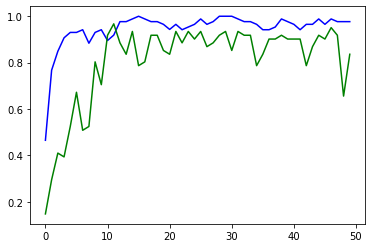

In [11]:

def plot_accuracy(history):
    acc = 'acc' if 'acc' in history else 'accuracy'
    val_acc = 'val_' + acc
    
    plt.plot(range(len(history[acc])), history[acc], color='b')
    plt.plot(range(len(history[val_acc])), history[val_acc], color='g')

    return hist.history[val_acc][-1]

plot_accuracy(hist.history)
print(max(hist.history['val_accuracy']))


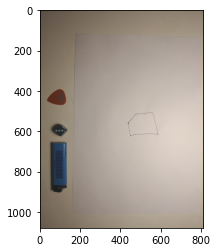

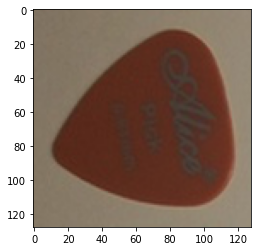

[6.5517416e-03 6.2108011e-06 5.6031971e-05 2.5744039e-01 4.3360921e-04
 7.2780406e-01 9.4995930e-06 7.6983743e-03] Крышка


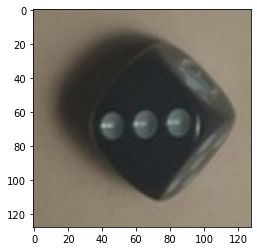

[3.6997002e-04 1.7464377e-02 5.0587259e-05 1.3106411e-03 5.5938419e-02
 3.0896786e-01 5.1876575e-01 9.7132429e-02] Кубик


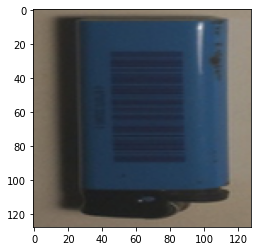

[2.4879860e-06 6.3915843e-07 9.9981636e-01 9.4611954e-09 4.4846377e-07
 2.2466729e-06 1.7702243e-04 7.7022696e-07] Зажигалка


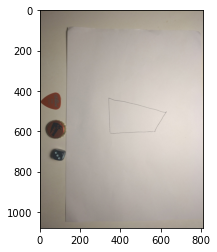

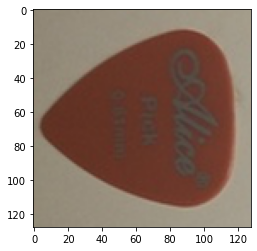

[1.2495490e-05 7.6528345e-08 2.8922525e-06 9.9958450e-01 1.0949758e-05
 3.7050093e-04 6.7130361e-07 1.7815313e-05] Медиатор


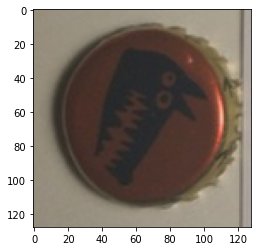

[1.3908742e-07 5.6140742e-08 4.9832188e-10 3.3668631e-08 7.9465201e-07
 9.9999809e-01 7.5245686e-07 1.7050955e-07] Крышка


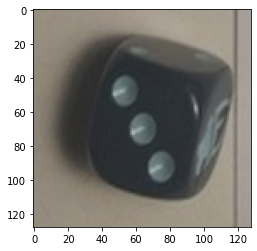

[1.49459065e-05 2.71092495e-06 2.16387048e-06 7.23380845e-06
 1.00890454e-03 5.69940638e-03 9.92395282e-01 8.69487179e-04] Кубик


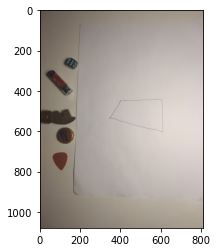

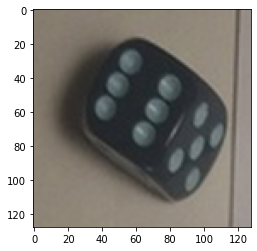

[6.5306956e-08 3.7593028e-07 3.1410497e-08 9.5072181e-08 1.5008000e-04
 4.0865320e-06 9.9983716e-01 8.0277241e-06] Кубик


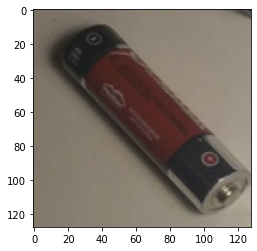

[2.7925571e-09 3.4017938e-10 1.1538914e-09 3.1982386e-10 8.3950393e-09
 2.0343458e-08 1.8100268e-08 1.0000000e+00] Батарейка


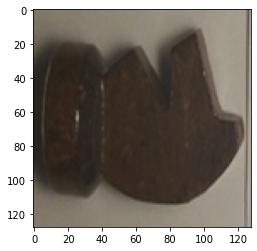

[1.90000410e-05 1.37064412e-01 2.81447569e-06 2.31533777e-05
 1.99165165e-01 5.51568449e-01 1.07608035e-01 4.54901019e-03] Крышка


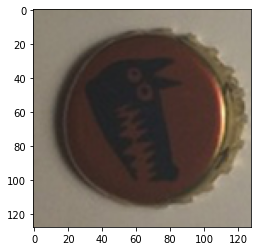

[9.7441770e-08 5.4844520e-08 8.2382340e-10 2.8904283e-08 2.4203870e-05
 9.9997115e-01 4.5070590e-07 3.9742713e-06] Крышка


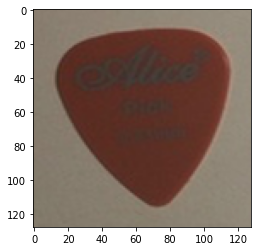

[3.5757908e-05 4.3274600e-08 1.1807147e-05 2.9280884e-02 1.4352458e-05
 8.7819159e-01 2.5793643e-06 9.2463091e-02] Крышка


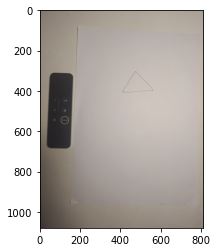

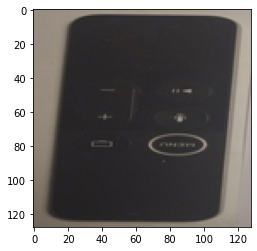

[1.0091092e-02 1.5167682e-01 3.4864137e-05 7.3202493e-05 7.0292693e-01
 7.4188121e-02 5.4071989e-02 6.9369213e-03] Шахматный конь


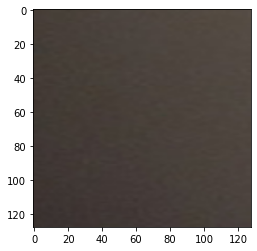

[9.5461232e-08 9.4545412e-01 8.0816963e-06 5.7252280e-05 2.1781349e-03
 4.5646764e-02 8.6828525e-04 5.7872823e-03] Пульт


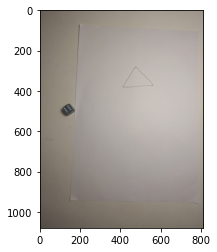

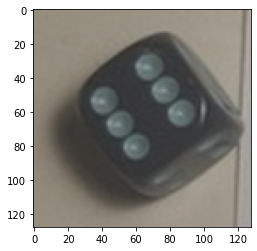

[5.32922911e-07 2.02890951e-04 2.54050633e-06 4.02140176e-05
 7.51917469e-05 3.65218526e-04 9.99301195e-01 1.21490775e-05] Кубик


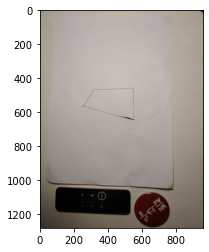

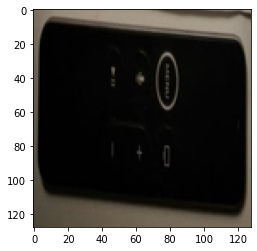

[8.8477891e-06 9.9958485e-01 1.1557108e-10 6.6392909e-09 1.6701344e-07
 2.9270691e-08 4.0601438e-04 1.2159099e-07] Пульт


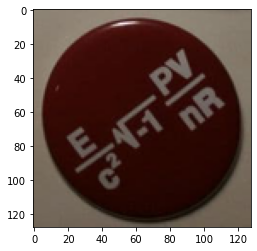

[9.9935216e-01 3.4449903e-07 3.2603745e-10 1.8075228e-06 1.6346622e-08
 6.4574077e-04 3.2966778e-08 3.3734706e-09] Значок


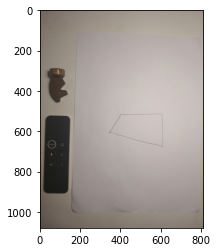

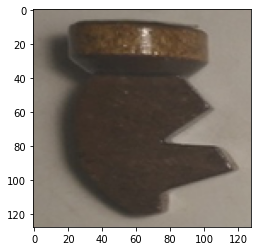

[2.73601996e-04 3.38303449e-04 1.53745696e-05 5.38537497e-05
 7.50716209e-01 4.64245714e-02 1.21055044e-01 8.11230764e-02] Шахматный конь


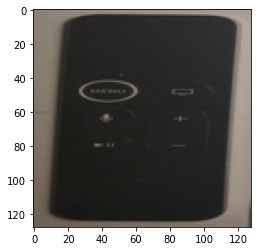

[3.49739423e-07 9.99980807e-01 1.48909010e-10 1.41030276e-09
 1.14114215e-07 8.41018775e-08 1.73789158e-05 1.13948226e-06] Пульт


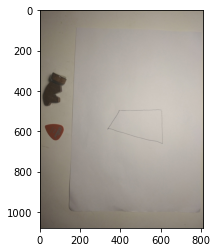

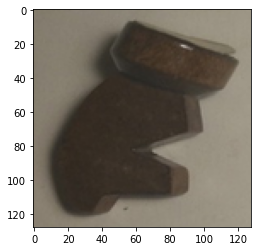

[7.4669733e-06 5.4513100e-03 3.4689633e-06 2.9961712e-04 7.2204220e-01
 1.3388968e-01 1.1934746e-01 1.8958792e-02] Шахматный конь


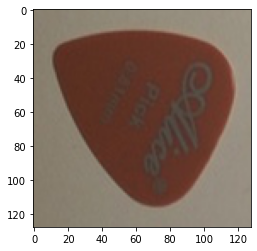

[1.2246033e-05 1.3024754e-08 1.5065729e-06 8.5602170e-03 2.6276088e-05
 9.9124181e-01 4.8073607e-06 1.5317187e-04] Крышка


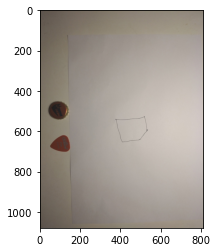

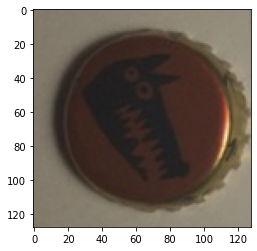

[1.82403789e-06 1.40844113e-05 1.34977585e-08 3.95941058e-08
 3.45655826e-05 9.99859452e-01 1.25700819e-06 8.87437127e-05] Крышка


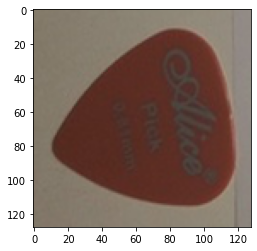

[6.4852140e-03 5.9731001e-06 7.4729258e-05 6.4934951e-01 2.4153425e-03
 3.0624521e-01 4.1148174e-05 3.5382878e-02] Медиатор


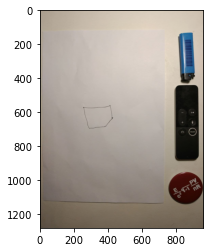

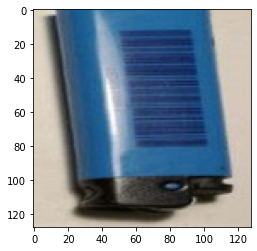

[1.6016643e-03 2.1602156e-05 6.2864876e-01 2.1880371e-06 7.9548183e-05
 4.0376042e-05 3.6958873e-01 1.7116357e-05] Зажигалка


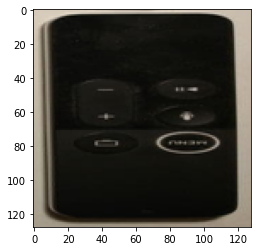

[2.6749377e-04 9.9002635e-01 3.8516450e-08 4.2469715e-08 9.5558027e-03
 2.3756278e-05 1.1786041e-04 8.7154349e-06] Пульт


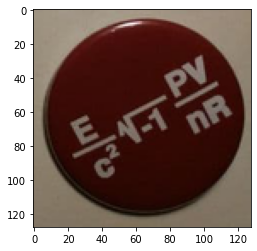

[9.9986291e-01 1.0051512e-09 1.3759647e-11 3.2054322e-07 2.5452196e-09
 1.3677038e-04 7.2274281e-10 8.1889207e-10] Значок


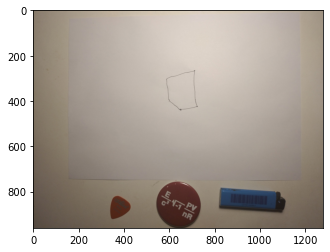

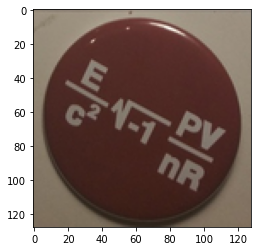

[9.9968135e-01 8.1922966e-09 3.0221745e-10 3.4592631e-07 6.0515481e-07
 2.2495189e-04 3.8472137e-07 9.2351678e-05] Значок


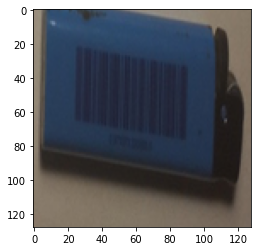

[8.4383555e-06 1.0647916e-06 9.7109467e-01 5.4829986e-08 5.9923845e-05
 1.2986666e-04 2.8705092e-02 9.2534259e-07] Зажигалка


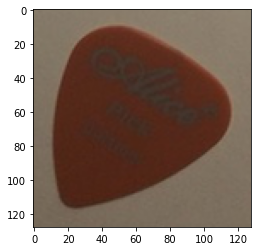

[1.21039955e-03 7.18478290e-08 4.91101027e-08 1.10637724e-04
 5.81470385e-06 9.97854292e-01 5.54414157e-07 8.18158442e-04] Крышка


In [96]:

fashion_clf.load_weights('best').expect_partial()
data = get_example_data()
datas = data[1:]
for img in datas:
    plt.imshow(img)
    plt.show()
    objects_boxes  = get_object_boxes(rgb2gray(img))
    objects = cut_objects_from_image(img, objects_boxes)
    res = fashion_clf.predict(np.array(objects))
    for indx, obj in enumerate(objects):
        plt.imshow(obj)
        plt.show()
        obj_indx = np.argmax(res[indx])
        print(res[indx], indx_to_name[obj_indx])
    #     res = fashion_clf.predict(obj)    



# Получение структуры фигуры

C:\Users\Admin\AppData\Local\Temp/ipykernel_11152/3134361073.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


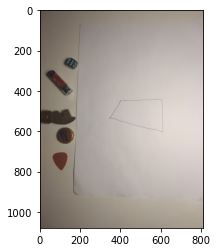

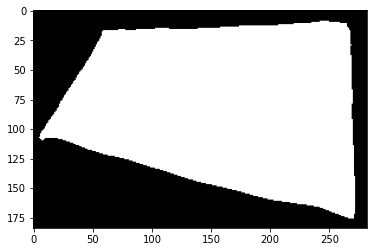

In [95]:
def cut_figure(img, edge_boxes):
    cut_figure = cut_objects_from_image(img, edge_boxes, resize = False)[0]
    edges = canny(rgb2gray(cut_figure), sigma=1.5, low_threshold=0.1) 
    figure = binary_fill_holes(binary_closing(edges, selem=np.ones((7, 7))))
    return figure


data = get_example_data()
img = data[3]
edge_boxes ,objects_boxes  = get_object_and_figure_boxes(rgb2gray(img))
plt.imshow(img)
plt.show()
figure = cut_figure(img,edge_boxes)
plt.imshow(figure, cmap = 'gray')


# Весь комлекс связанный с извлечением фигуры и классификацией

C:\Users\Admin\AppData\Local\Temp/ipykernel_11152/3134361073.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


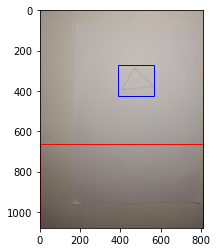

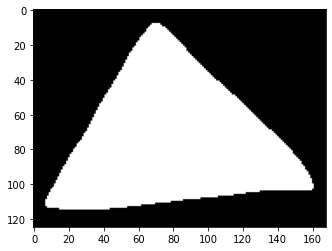

0.963 Зажигалка


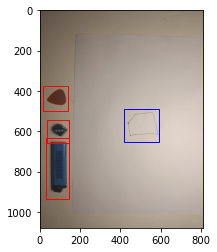

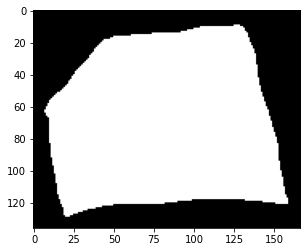

0.728 Крышка
0.519 Кубик
1.0 Зажигалка


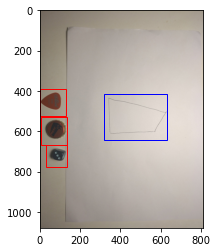

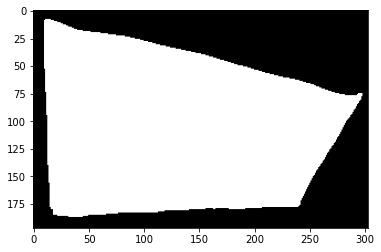

1.0 Медиатор
1.0 Крышка
0.992 Кубик


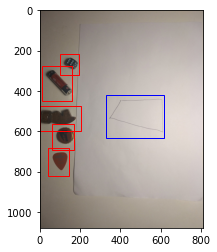

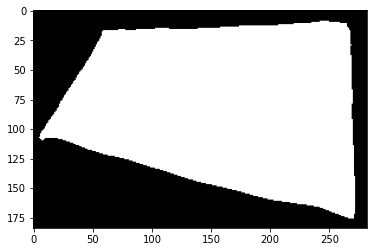

1.0 Кубик
1.0 Батарейка
0.552 Крышка
1.0 Крышка
0.878 Крышка


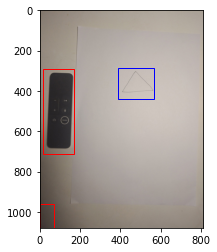

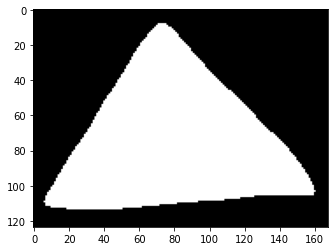

0.703 Шахматный конь
0.945 Пульт


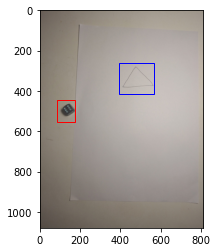

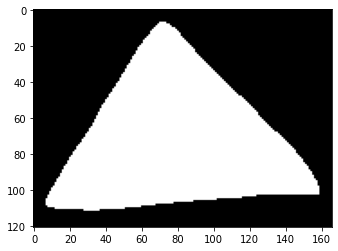

0.999 Кубик


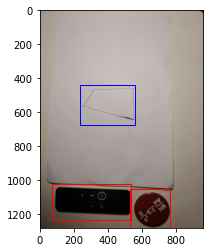

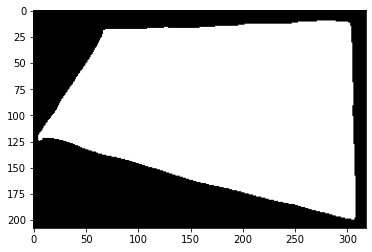

1.0 Пульт
0.999 Значок


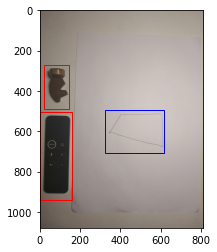

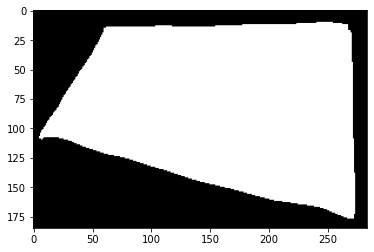

0.751 Шахматный конь
1.0 Пульт


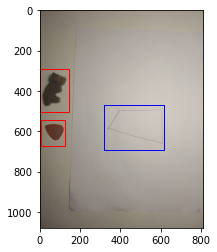

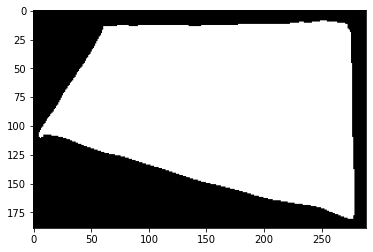

0.722 Шахматный конь
0.991 Крышка


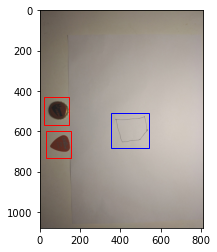

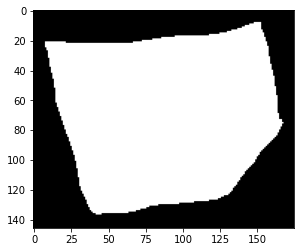

1.0 Крышка
0.649 Медиатор


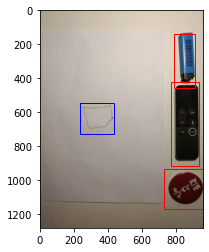

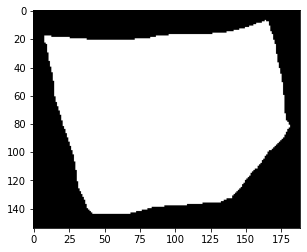

0.629 Зажигалка
0.99 Пульт
1.0 Значок


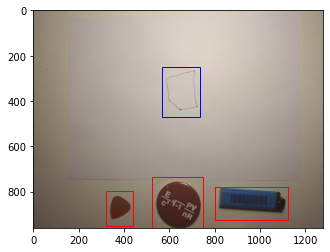

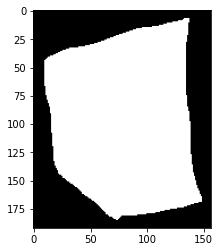

1.0 Значок
0.971 Зажигалка
0.998 Крышка


In [94]:

def classify_objects(cut_objects, classes = 8):
    model = make_fashion_model(num_classes = classes)
    model.load_weights('best').expect_partial()
    res = model.predict(np.array(cut_objects))
    return res

def extract_fig_and_objects(img, show_boxes = False):
    edge_boxes, objects_boxes  = get_object_and_figure_boxes(rgb2gray(img))
    if show_boxes:
        fig, ax = plt.subplots()
        ax.imshow(img)
        for box in objects_boxes:
            min_row, min_col, max_row, max_col = box
            ax.add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='r', facecolor='none'))
        #TODO ПРОВЕРКА ЧТО ФИГУРА ТОЛЬКО ОДНА
        for box in edge_boxes:
            min_row, min_col, max_row, max_col = box
            ax.add_patch(patches.Rectangle((max(min_col-20,0),max(min_row-20, 0)),  max_col- min_col+30, max_row - min_row + 50,linewidth=1, edgecolor='b', facecolor='none'))
        plt.show()
    cut_objects = cut_objects_from_image(img,objects_boxes)
    figure = cut_figure(img, edge_boxes)
    class_objects = classify_objects(cut_objects)
    return figure,edge_boxes[:2] ,class_objects



for elem in data:
#     plt.imshow(elem)
#     plt.show()
    figure, _, class_objects = extract_fig_and_objects(elem, show_boxes = True)
    plt.imshow(figure, cmap = 'gray')
    plt.show()
    for obj in class_objects:
        obj_indx = np.argmax(obj)
        print(round(obj[obj_indx],3), indx_to_name[obj_indx])









# Создание структур объектов
Мы классифицируем объекты, чтобы можно было воспользоваться уже созданной для них структурой

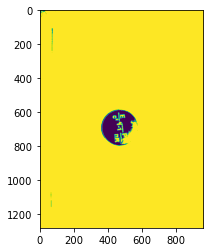

1


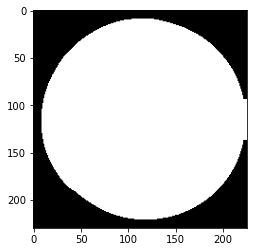

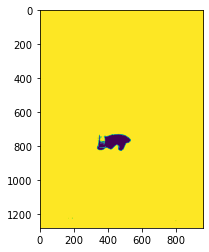

1


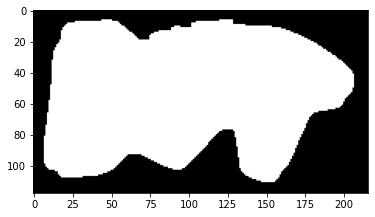

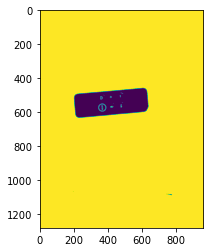

1


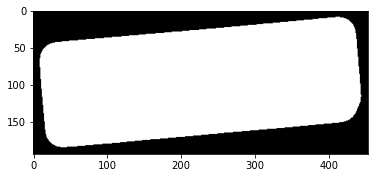

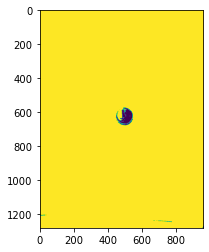

1


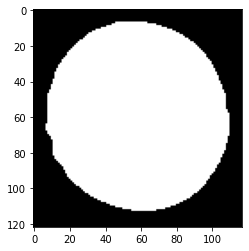

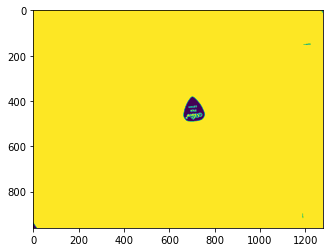

1


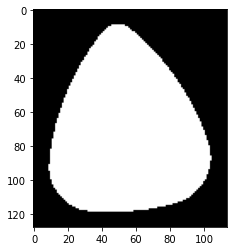

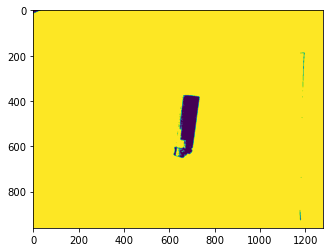

1


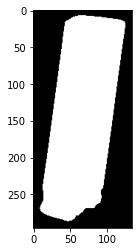

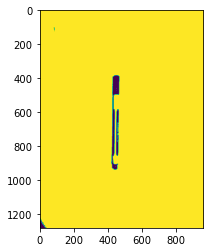

2


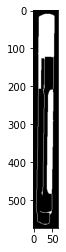

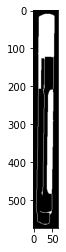

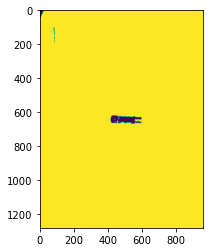

1


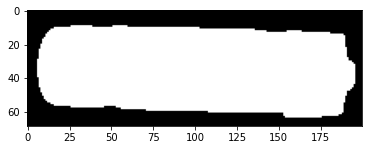

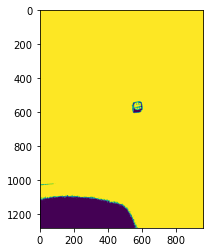

2


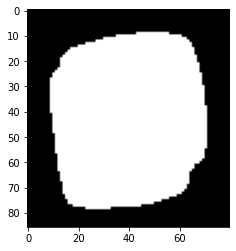

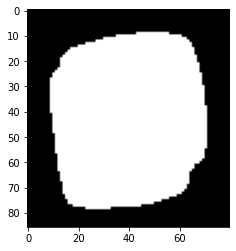

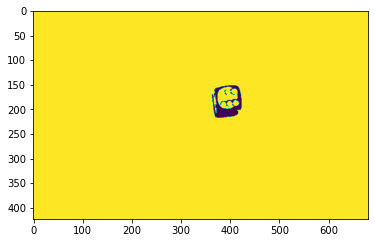

1


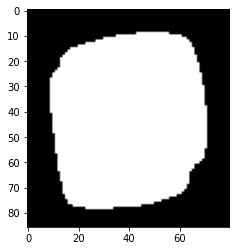

In [29]:
path = "imgs_for_structure"
save_path = "objects_figure"

for indx, file in enumerate(os.listdir(path)):
    img = imread(os.path.join(path, file))
    objects_boxes  = get_object_boxes(rgb2gray(img))
    for obj in objects_boxes:
        res = cut_figure(img , objects_boxes)
        plt.imshow(res, cmap = 'gray')
        plt.show()
        imsave(os.path.join(save_path,f"{indx}.jpg" ), 255 * res.astype("uint8"))

# Самая простая версия размещения одного в другое
Возьмем фотку, вытащим из нее фигуру на бумаге, классифицируем объекты, достанем их структуру.
И попробуем пихнуть.
И назовем это успехом и концом на сегодня

C:\Users\Admin\AppData\Local\Temp/ipykernel_11152/3134361073.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_img = rgb2gray(main_img)


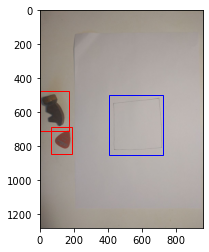

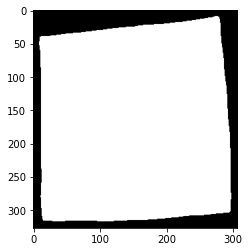

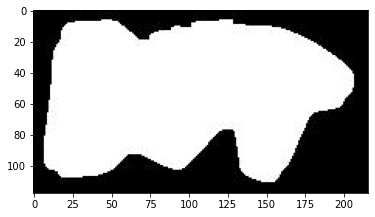

0.566 Шахматный конь


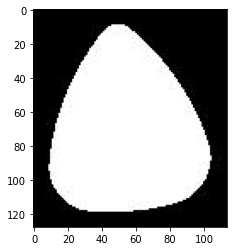

0.997 Медиатор


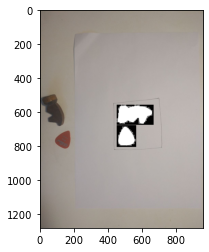

In [93]:
def slide_obj_over_fig(main_figure, obj, object_area):
    fig_y, fig_x = main_figure.shape
    obj_y, obj_x = obj.shape
    for pos_y in range(0, fig_y - obj_y, 20):
        for pos_x in range(0, fig_x - obj_x, 20):
            roi = main_figure[pos_y:pos_y+obj_y, pos_x:pos_x+obj_x].astype(int)
            intersect = cv.bitwise_and(roi,obj.astype(int))
            if np.sum(intersect) == object_area:
                main_figure[pos_y:pos_y+obj_y, pos_x:pos_x+obj_x] = obj.astype(bool)
                return (pos_y, pos_x), main_figure
                
    return (-1,-1), main_figure


path = 'work/easy_img.jpg'
figures = "objects_figure"
#  {0:"Значок" , 1:"Пульт", 2:"Зажигалка", 3: "Медиатор", 4: "Шахматный конь", 5:"Крышка", 6: "Кубик", 7: "Батарейка"}
figure_struct_paths =  {0:"0.jpg" , 1:"2.jpg", 2:"5.jpg", 3: "4.jpg", 4: "1.jpg", 5:"3.jpg", 6: "8.jpgк", 7: "7.jpg"}
img = imread(path)

figure, fig_location, class_objects = extract_fig_and_objects(img, show_boxes = True)


plt.imshow(figure, cmap = 'gray')
plt.show()
objects_structures = []
for obj in class_objects:
    obj_indx = np.argmax(obj)
    struct = imread(os.path.join(figures,figure_struct_paths[obj_indx]))
    plt.imshow(struct, cmap = 'gray')
    plt.show()
    struct = struct/255 > 0
    objects_structures.append(struct)
    print(round(obj[obj_indx],3), indx_to_name[obj_indx])

object_areas = []
for elem in objects_structures:
    area =  np.sum(elem)
    object_areas.append(area)


object_loc = []
for obj, area in zip(objects_structures,object_areas ):
    (y,x), figure = slide_obj_over_fig(figure, obj, area )
    object_loc.append([y,x])
    if x!= -1:
        plt.imshow(figure, cmap = 'gray')
    else:
        print("nope")
        
for obj, location in zip(objects_structures,object_loc ):
    y_fig, x_fig, *_ =  fig_location[0]
    y, x = location
    obj_y, obj_x = obj.shape
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 0] = 255 * obj.astype(int)
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 1] = 255 * obj.astype(int)
    img[y_fig+y:y_fig+y+obj_y, x_fig+x:x_fig+x+obj_x, 2]  = 255 * obj.astype(int)
    
    
plt.imshow(img)